# MAAI-Pratical_Work- Sistema de Previsão de Depressão Estudantil
## Feito por : Jose Afonso Pereira Monteiro Nº : 21083






## Business Goals

### Objetivos principais
Desenvolver um sistema para prever se um aluno estaria em risco de depressao com base nos dados demograficos,habitos de estudo e estilo de vida para responder as seguintes questões:
  - podemos prever se um estudante está em risco de depressão?
  - Quais fatores acadêmicos, psicológicos e de estilo de vida melhor prevem o risco de depressão em estudantes universitários?

O objetivo geral deste estudo é desenvolver e implementar um sistema completo de previsão de depressão estudantil. Os objetivos específicos incluem:
1) Realizar análise exploratória abrangente das características dos estudantes
2) Identificar parâmetros otimos para modelagem preditiva
3) Analisar a relação entre fatores de risco e probabilidade de depressão





## Importaçao de bibliotecas


- importamos todas as bibliotecas necessárias para a análise de dados, visualização, pré-processamento e modelagem.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix,classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

## Carregamento e Exploração Inicial do Dataset


- Carregamos o dataset e realizamos uma exploração inicial para entender sua estrutura, dimensões e conteúdo

In [21]:

#Carregar dados
df=pd.read_csv("student_depression_dataset.csv")

# Informações gerais do dataset
print("DATASET ORGINAL")
print(f"Dimensoes: {df.shape}")
print(f"Colunas: {df.columns.tolist()}")
# Primeiras linhas do dataset
print(f"\nPrimeiras 5 linhas do dataset:")
display(df.head())    


DATASET ORGINAL
Dimensoes: (27901, 18)
Colunas: ['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']

Primeiras 5 linhas do dataset:


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


## Exploração Detalhada do Dataset

- Aqui realizamos uma análise mais detalhada dos tipos de dados, valores únicos, estatísticas descritivas, valores nulos e duplicados.

features disponiveis:['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']

Tipos de dados:


,Coluna,Tipo,Valores Únicos
0,id,int64,27901
1,Gender,object,2
2,Age,float64,34
3,City,object,52
4,Profession,object,14
5,Academic Pressure,float64,6
6,Work Pressure,float64,3
7,CGPA,float64,332
8,Study Satisfaction,float64,6
9,Job Satisfaction,float64,5


                  id           Age  Academic Pressure  Work Pressure  \
count   27901.000000  27901.000000       27901.000000   27901.000000   
mean    70442.149421     25.822300           3.141214       0.000430   
std     40641.175216      4.905687           1.381465       0.043992   
min         2.000000     18.000000           0.000000       0.000000   
25%     35039.000000     21.000000           2.000000       0.000000   
50%     70684.000000     25.000000           3.000000       0.000000   
75%    105818.000000     30.000000           4.000000       0.000000   
max    140699.000000     59.000000           5.000000       5.000000   

               CGPA  Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count  27901.000000        27901.000000      27901.000000      27901.000000   
mean       7.656104            2.943837          0.000681          7.156984   
std        1.470707            1.361148          0.044394          3.707642   
min        0.000000            0.00

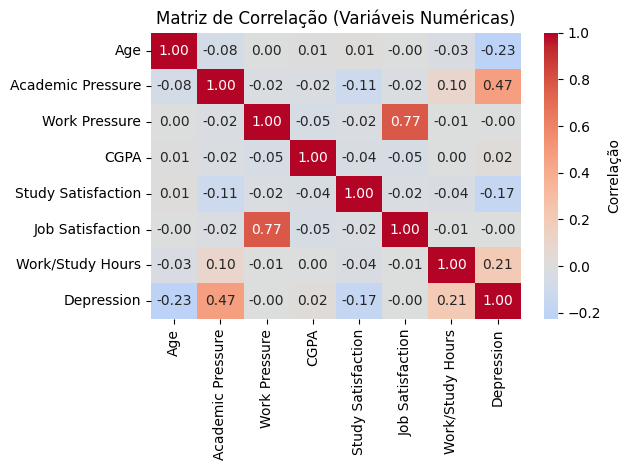

In [22]:
#features disponiveis no dataset
features =['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
            'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
              'Financial Stress', 'Family History of Mental Illness', 'Depression']
print(f"features disponiveis:{features}")

#Tipos de dados
print("\nTipos de dados:")
tipos_dados = pd.DataFrame({
    'Coluna': df.columns,
    'Tipo': df.dtypes.values,
    'Valores Únicos': [df[col].nunique() for col in df.columns]
})
display(tipos_dados)   
print(df.describe())

#valores nulos e duplicados
print(f"Total Valores nulos: {df.isnull().sum().sum()}")
print(f"Valores nulos:\n{df.isnull().sum()}")
print(f"\nLinhas duplicadas: {df.duplicated().sum()}")
print(f"Total de linhas no dataset: {df.shape[0]}") 
  
  
corr_cols = ['Age','Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
            'Job Satisfaction','Work/Study Hours', 'Depression']
corr_matrix = df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Correlação (Variáveis Numéricas)')
plt.tight_layout()

## Limpeza e Pré-processamento de Dados


- Nesta seção, realizamos a limpeza dos dados, tratando valores nulos, removendo colunas irrelevantes e preparando o dataset para modelagem.

As Colunas removidas foram selecionadas pelo os seguintes motivos:
- limitavam muito a seleçao do utilizador como o 'City','Profession'
- irrelevantes como por exemplo o 'id'
- porque ao verificar a importancia de cada variavel apos o treinamento do modelo,a importancia ser zero ou muito baixa

In [23]:
df_copy=df.copy()

print(f"Features atuais: {list(df_copy.columns)}")
print(f"Valores nulos: {df_copy.isnull().sum().sum()}")
print(f"Linhas duplicadas: {df_copy.duplicated().sum()}")
print(f"Total de linhas no dataset: {df.shape[0]}") 

#features numericas
numericas =df_copy.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nfeatures numericas:{numericas}")
#valores nulos preenchidos com mediana
df_copy[numericas] = df_copy[numericas].fillna(df_copy[numericas].median())
print(f"valores nulos preenchidos com mediana")

#features categoricas
categoricas=df_copy.select_dtypes(include=['object']).columns.tolist()
print(f"\nfeatures categoricas:{categoricas}")
#valores nulos preenchidos com moda
df_copy[categoricas] = df_copy[categoricas].fillna(df_copy[categoricas].mode().iloc[0])
print(f"valores nulos preenchidos com moda")

# verificar nulos apos limpeza
print(f"Total de valores nulos depois da limpeza: {df_copy.isnull().sum().sum()}")

# Remover colunas redundantes/desnecessárias
cols_to_drop = ['id',#nao vai ser necessario para a previsao 
                'City',# para ser menos limitante mais generalizado 
                'Profession',# para ser menos limitante mais generalizado 
                'Degree',# importancia muito baixa
                'Work Pressure',# importancia muito baixa
                'Job Satisfaction'# importancia muito baixa
                ]
df_copy = df_copy.drop(columns=[c for c in cols_to_drop if c in df_copy.columns])
print(f"\nColunas removidas: {cols_to_drop}")
print(f"Features finais: {list(df_copy.columns)}")

# Exibir as primeiras linhas do dataset após o pré-processamento
print(f"\nPrimeiras 5 linhas do dataset:")
display(df_copy.head())  

#Features finais e dimensoes
print(f"\nDataset após pré-processamento: {df_copy.shape}")
print(f"Colunas finais ({len(df_copy.columns)}):")
for i, col in enumerate(df_copy.columns, 1):
    if col =='Depression':
     print(f"{i}. {col}(target)")
    else:
       print(f"{i}. {col}")

       

Features atuais: ['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
Valores nulos: 0
Linhas duplicadas: 0
Total de linhas no dataset: 27901

features numericas:['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Depression']
valores nulos preenchidos com mediana

features categoricas:['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness']
valores nulos preenchidos com moda
Total de valores nulos depois da limpeza: 0

Colunas removidas: ['id', 'City', 'Profession', 'Degree', 'Work Pressure', 'Job Satisfaction']
Features finais: ['Gender', 'Age'

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33.0,5.0,8.97,2.0,'5-6 hours',Healthy,Yes,3.0,1.0,No,1
1,Female,24.0,2.0,5.90,5.0,'5-6 hours',Moderate,No,3.0,2.0,Yes,0
2,Male,31.0,3.0,7.03,5.0,'Less than 5 hours',Healthy,No,9.0,1.0,Yes,0
3,Female,28.0,3.0,5.59,2.0,'7-8 hours',Moderate,Yes,4.0,5.0,Yes,1
4,Female,25.0,4.0,8.13,3.0,'5-6 hours',Moderate,Yes,1.0,1.0,No,0



Dataset após pré-processamento: (27901, 12)
Colunas finais (12):
1. Gender
2. Age
3. Academic Pressure
4. CGPA
5. Study Satisfaction
6. Sleep Duration
7. Dietary Habits
8. Have you ever had suicidal thoughts ?
9. Work/Study Hours
10. Financial Stress
11. Family History of Mental Illness
12. Depression(target)


##  Análise da Variável Target 'Depression'

Esta seção analisa a distribuição da variável alvo (Depression), que é o que queremos prever. É crucial entender o balanceamento das classes antes de treinar o modelo.

Valores únicos em 'Depression': [1 0]
Tipo de dados: int64

Distribuição de 'Depression':
Depression
1    58.549873
0    41.450127
Name: proportion, dtype: float64


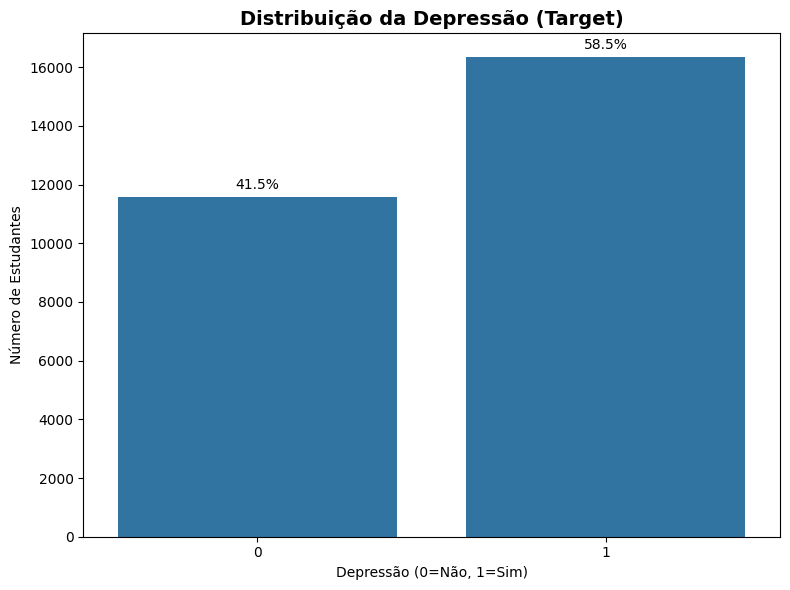

In [24]:
# Verificar valores únicos
print(f"Valores únicos em 'Depression': {df_copy['Depression'].unique()}")
print(f"Tipo de dados: {df_copy['Depression'].dtype}")

# Distribuição
depression_dist = df_copy['Depression'].value_counts(normalize=True) * 100
print(f"\nDistribuição de 'Depression':")
print(depression_dist)

# Visualizar
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_copy, x='Depression')
plt.title('Distribuição da Depressão (Target)', fontsize=14, fontweight='bold')
plt.xlabel('Depressão (0=Não, 1=Sim)')
plt.ylabel('Número de Estudantes')

# Adicionar percentagens
total = len(df_copy)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y_height = p.get_height()
    ax.annotate(percentage, (x, y_height + total*0.01), ha='center')

plt.tight_layout()
plt.show()


## Preparação de Dados para Codificação

Esta seção identifica e separa as variáveis categóricas e numéricas do dataset após o pré-processamento. Esta separação é crucial porque:
1. Variáveis categóricas precisam ser convertidas para formato numérico (através de Label Encoding ou One-Hot Encoding)
2. Variáveis numéricas podem precisar de normalização ou padronização
3. Diferentes tipos de variáveis requerem diferentes tratamentos antes da modelagem

In [25]:
 # Identificar categóricas
categorical_features = df_copy.select_dtypes(include=['object']).columns.tolist()
numerical_features = df_copy.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nVariáveis Categóricas ({len(categorical_features)}):")
print(f"  {categorical_features}")
print(f"\nVariáveis Numéricas ({len(numerical_features)}):")
print(f"  {numerical_features}")


Variáveis Categóricas (6):
  ['Gender', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness']

Variáveis Numéricas (6):
  ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours', 'Depression']


## Encoding de Features Categóricas

Esta seção converte todas as variáveis categóricas em formato numérico através de diferentes técnicas de encoding. O encoding é necessário porque a maioria dos algoritmos de machine learning só trabalha com dados numéricos. Aqui utilizamos duas abordagens diferentes baseadas no tipo de variável:

1. **Label Encoding para variáveis binárias**: Variáveis com apenas duas categorias
2. **Mapeamento manual para variáveis ordinais**: Variáveis com ordem natural entre as categorias

In [26]:
# Criar cópia para não afetar original
df_encoded = df_copy.copy()

#VARIÁVEIS BINÁRIAS - LabelEncoder
print("\n" + "="*40)
print("VARIÁVEIS BINÁRIAS")
print("="*40)
binary_cols = ['Gender','Family History of Mental Illness','Have you ever had suicidal thoughts ?']

for col in binary_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        encoded_col = f"{col}_encoded"
        df_encoded[encoded_col] = le.fit_transform(df_encoded[col].astype(str))
       
        
        print(f"\n{col}:")
        print(f"   Original: {df_encoded[col].unique()}")
        print(f"   Encoded:  {df_encoded[encoded_col].unique()}")

#VARIÁVEIS ORDINAIS -Mapeamento manual
print("\n" + "="*40)
print("VARIÁVEIS ORDINAIS")
print("="*40)

#Sleep Duration
if 'Sleep Duration' in df_encoded.columns:
    print(f"\nSleep Duration - Ordem lógica:")
    # Primeiro: limpar as aspas extras
    df_encoded['Sleep Duration'] = df_encoded['Sleep Duration'].str.replace("'", "")
    
    # Mapeamento(ordem crescente de horas)
    sleep_mapping = {
        'Less than 5 hours': 1,    # Muito pouco
        '5-6 hours': 2,            # Pouco
        '7-8 hours': 3,            # Normal/Recomendado
        'More than 8 hours': 4,    # Muito
        'Others': 2.5              # Intermediário (como pode ser mais ou menos)
    }
    
    df_encoded['Sleep Duration_encoded'] = df_encoded['Sleep Duration'].map(sleep_mapping)
    print(f"   Mapeamento aplicado: {sleep_mapping}")
    print(f"   Valores únicos após: {sorted(df_encoded['Sleep Duration_encoded'].unique())}")

# Dietary Habits
if 'Dietary Habits' in df_encoded.columns:
    print(f"\nDietary Habits - Ordem de saúde:")
    
    dietary_mapping = {
        'Unhealthy': 1,     # Menos saudável
        'Others': 2,        # Neutro/Desconhecido
        'Moderate': 3,      # Moderado
        'Healthy': 4        # Mais saudável
    }
    
    df_encoded['Dietary Habits_encoded'] = df_encoded['Dietary Habits'].map(dietary_mapping) 
    print(f"   Mapeamento aplicado: {dietary_mapping}")
    print(f"   Valores únicos após: {sorted(df_encoded['Dietary Habits_encoded'].unique())}")

#Financial Stress
if 'Financial Stress' in df_encoded.columns:
    print(f"\nFinancial Stress - Escala 1-5:")
    
    # Converter para string para tratamento uniforme
    df_encoded['Financial Stress'] = df_encoded['Financial Stress'].astype(str)
    
    financial_mapping = {
        '1.0': 1, '1': 1,   # Baixo stress
        '2.0': 2, '2': 2,
        '3.0': 3, '3': 3,   # Moderado
        '4.0': 4, '4': 4,
        '5.0': 5, '5': 5,   # Alto stress
        '?': 3,   # Tratar como moderado
    }
    
    df_encoded['Financial Stress_encoded'] = df_encoded['Financial Stress'].map(financial_mapping)
    print(f"   Mapeamento aplicado: {financial_mapping}")
    print(f"   Valores únicos após: {sorted(df_encoded['Financial Stress_encoded'].unique())}")


#REMOVER COLUNAS ORIGINAIS CATEGÓRICAS
print("\n" + "="*60)
print("LIMPEZA E ORGANIZAÇÃO FINAL")
print("="*60)

# Listar todas as colunas codificadas criadas
encoded_columns = [col for col in df_encoded.columns if '_encoded' in col]
print(f"\nColunas codificadas criadas ({len(encoded_columns)}):")
for col in encoded_columns:
    print(f"-{col}")

#remover colunas originais categóricas
cols_to_drop = [col for col in categorical_features if col in df_encoded.columns]
df_encoded = df_encoded.drop(columns=cols_to_drop, errors='ignore')

print(f"\nColunas categóricas originais removidas: {cols_to_drop}")

# Verificar resultado final
print(f"\nDataset após encoding:")
print(f"Shape: {df_encoded.shape}")
print(f"Colunas: {list(df_encoded.columns)}")
print(f"Tipos de dados:")
print(df_encoded.dtypes.value_counts())


VARIÁVEIS BINÁRIAS

Gender:
   Original: ['Male' 'Female']
   Encoded:  [1 0]

Family History of Mental Illness:


   Original: ['No' 'Yes']
   Encoded:  [0 1]

Have you ever had suicidal thoughts ?:
   Original: ['Yes' 'No']
   Encoded:  [1 0]

VARIÁVEIS ORDINAIS

Sleep Duration - Ordem lógica:
   Mapeamento aplicado: {'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4, 'Others': 2.5}
   Valores únicos após: [np.float64(1.0), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(4.0)]

Dietary Habits - Ordem de saúde:
   Mapeamento aplicado: {'Unhealthy': 1, 'Others': 2, 'Moderate': 3, 'Healthy': 4}
   Valores únicos após: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Financial Stress - Escala 1-5:
   Mapeamento aplicado: {'1.0': 1, '1': 1, '2.0': 2, '2': 2, '3.0': 3, '3': 3, '4.0': 4, '4': 4, '5.0': 5, '5': 5, '?': 3}
   Valores únicos após: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

LIMPEZA E ORGANIZAÇÃO FINAL

Colunas codificadas criadas (6):
-Gender_encoded
-Family History of Mental Illness_encoded
-Have you ever had suicidal 

## Separação de Features e Target

Nesta etapa, separamos o dataset em duas partes:
1. **X (Features)**: Todas as variáveis preditoras que serão usadas para fazer as previsões
2. **y (Target)**: A variável que queremos prever (Depression - 0 ou 1)

Esta separação é necessária porque os algoritmos de machine learning aprendem a relação entre X e y, e depois usam essa relação para fazer previsões em novos dados.

In [27]:
# Remover coluna target das features
X = df_encoded.drop('Depression', axis=1)
#variável target
y = df_encoded['Depression'].copy()

print(f"Shape final:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")

# Verificar tipos de dados em X
print(f"\nTipos de dados em X:")
print(X.dtypes.value_counts())

Shape final:
  X (features): (27901, 11)
  y (target): (27901,)

Tipos de dados em X:
float64    6
int64      5
Name: count, dtype: int64


## Divisão dos Dados em Conjuntos de Treino e Teste


Nesta etapa, dividimos o dataset em dois subconjuntos:
- **Conjunto de Treino (80%)**: Usado para treinar o modelo
- **Conjunto de Teste (20%)**: Usado para avaliar o modelo em dados não vistos

 O parâmetro **stratify=y** garante que a proporção das classes seja mantida em ambos os conjuntos,garantindo que tenham a mesma proporção de classes deprimidas/não deprimidas.

 O parâmetro **Random State = 42** garante reprodutibilidade, sempre obterá a mesma divisão.
 
 A **Proporção 80/20** e suficiente para o modelo aprender padrões complexos.

In [28]:
# Dividir mantendo proporção das classes (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, # Features
    y, # Target
    test_size=0.2,#20% para teste|80% para treino 
    random_state=42,#para reprodutibilidade 
    stratify=y#manter proporção das classes
)

print(f" Divisão estratificada:")
print(f"Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X):.1%})")
print(f"Teste:  {X_test.shape[0]} amostras ({X_test.shape[0]/len(X):.1%})")

print(f"\n Distribuição no Treino:")
train_dist = y_train.value_counts(normalize=True) * 100
print(f"Classe 0: {train_dist[0]:.1f}%")
print(f"Classe 1: {train_dist[1]:.1f}%")

print(f"\nDistribuição no Teste:")
test_dist = y_test.value_counts(normalize=True) * 100
print(f"Classe 0: {test_dist[0]:.1f}%")
print(f"Classe 1: {test_dist[1]:.1f}%")

 Divisão estratificada:
Treino: 22320 amostras (80.0%)
Teste:  5581 amostras (20.0%)

 Distribuição no Treino:
Classe 0: 41.5%
Classe 1: 58.5%

Distribuição no Teste:
Classe 0: 41.4%
Classe 1: 58.6%


## Normalização das Features

Nesta etapa, aplicamos a normalização (StandardScaler) às features numéricas para garantir que todas tenham a mesma escala.O 

**StandardScaler** transforma os dados para ter média 0 e desvio padrão 1


## -Por que usar StandardScaler?


   - **Robusto a outliers**: Menos sensível que MinMaxScaler
   - **Preserva distribuição**: Mantém a forma da distribuição original
   - **Interpretabilidade**: Valores em unidades de desvio padrão


In [29]:
print("\n" + "="*60)
print("NORMALIZAÇÃO DAS FEATURES")
print("="*60)
# Identificar colunas numéricas
num_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()

# Aplicar apenas nas colunas numéricas
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Aplicar normalização
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print(f"{len(num_cols)} features numéricas normalizadas:")
for col in num_cols:
  print(f"{col}")


NORMALIZAÇÃO DAS FEATURES
11 features numéricas normalizadas:
Age
Academic Pressure
CGPA
Study Satisfaction
Work/Study Hours
Gender_encoded
Family History of Mental Illness_encoded
Have you ever had suicidal thoughts ?_encoded
Sleep Duration_encoded
Dietary Habits_encoded
Financial Stress_encoded


## Comparação de Múltiplos Modelos de Classificação

Nesta seção, implementamos uma comparação sistemática de 6 diferentes algoritmos de machine learning para identificar qual tem o melhor desempenho na previsão de risco de depressão. Esta abordagem é essencial porque:

1. **Diferentes algoritmos têm diferentes pontos fortes**: Alguns são melhores com dados lineares, outros com não-lineares
2. **Evita viés de algoritmo único**: Não assumimos que um algoritmo específico é o melhor
3. **Identificação do algoritmo mais adequado**: Baseado nas características específicas do nosso dataset

### Algoritmos Comparados:

| Algoritmo | Pontos Fortes | Pontos Fracos | Melhor para |
|-----------|--------------|---------------|-------------|
| **Logistic Regression** | Interpretável, rápido, bom baseline | Linear apenas | Relações lineares |
| **Decision Tree** | Interpretável, não precisa normalização | Overfitting fácil | Datasets pequenos |
| **Random Forest** | Reduz overfitting, robusto | Menos interpretável | Classificação geral |
| **Gradient Boosting** | Alta performance, combina árvores | Lento, overfitting se mal ajustado | Competições Kaggle |
| **XGBoost** | Otimizado, rápido, boa performance | Hiperparâmetros complexos | Performance extrema |
| **Naive Bayes** | Muito rápido, bom com features independentes | Suposição ingênua (independência) | Texto, datasets grandes |


Treinando e avaliando modelos...

Logistic Regression...
 Treinado em 0.02s
  Accuracy: 0.8418, F1-Score: 0.8622

Decision Tree...
 Treinado em 0.07s
  Accuracy: 0.7674, F1-Score: 0.8018

Random Forest...
 Treinado em 0.30s
  Accuracy: 0.8378, F1-Score: 0.8638

Gradient Boosting...
 Treinado em 1.28s
  Accuracy: 0.8470, F1-Score: 0.8715

XGBoost...
 Treinado em 0.08s
  Accuracy: 0.8341, F1-Score: 0.8604

Naive Bayes...
 Treinado em 0.02s
  Accuracy: 0.8395, F1-Score: 0.8625

RESULTADOS DA COMPARACAO DE MODELOS

Ordenado por F1-Score (melhor para dados desbalanceados):
                     Accuracy  Precision  Recall  F1-Score  AUC-ROC  Time (s)
Gradient Boosting      0.8470     0.8571  0.8865    0.8715   0.9195    1.2782
Random Forest          0.8378     0.8499  0.8782    0.8638   0.9130    0.2992
Naive Bayes            0.8395     0.8649  0.8602    0.8625   0.9164    0.0182
Logistic Regression    0.8418     0.8799  0.8452    0.8622   0.9188    0.0204
XGBoost                0.8341     

c:\Users\JoseAfonso\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:59:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


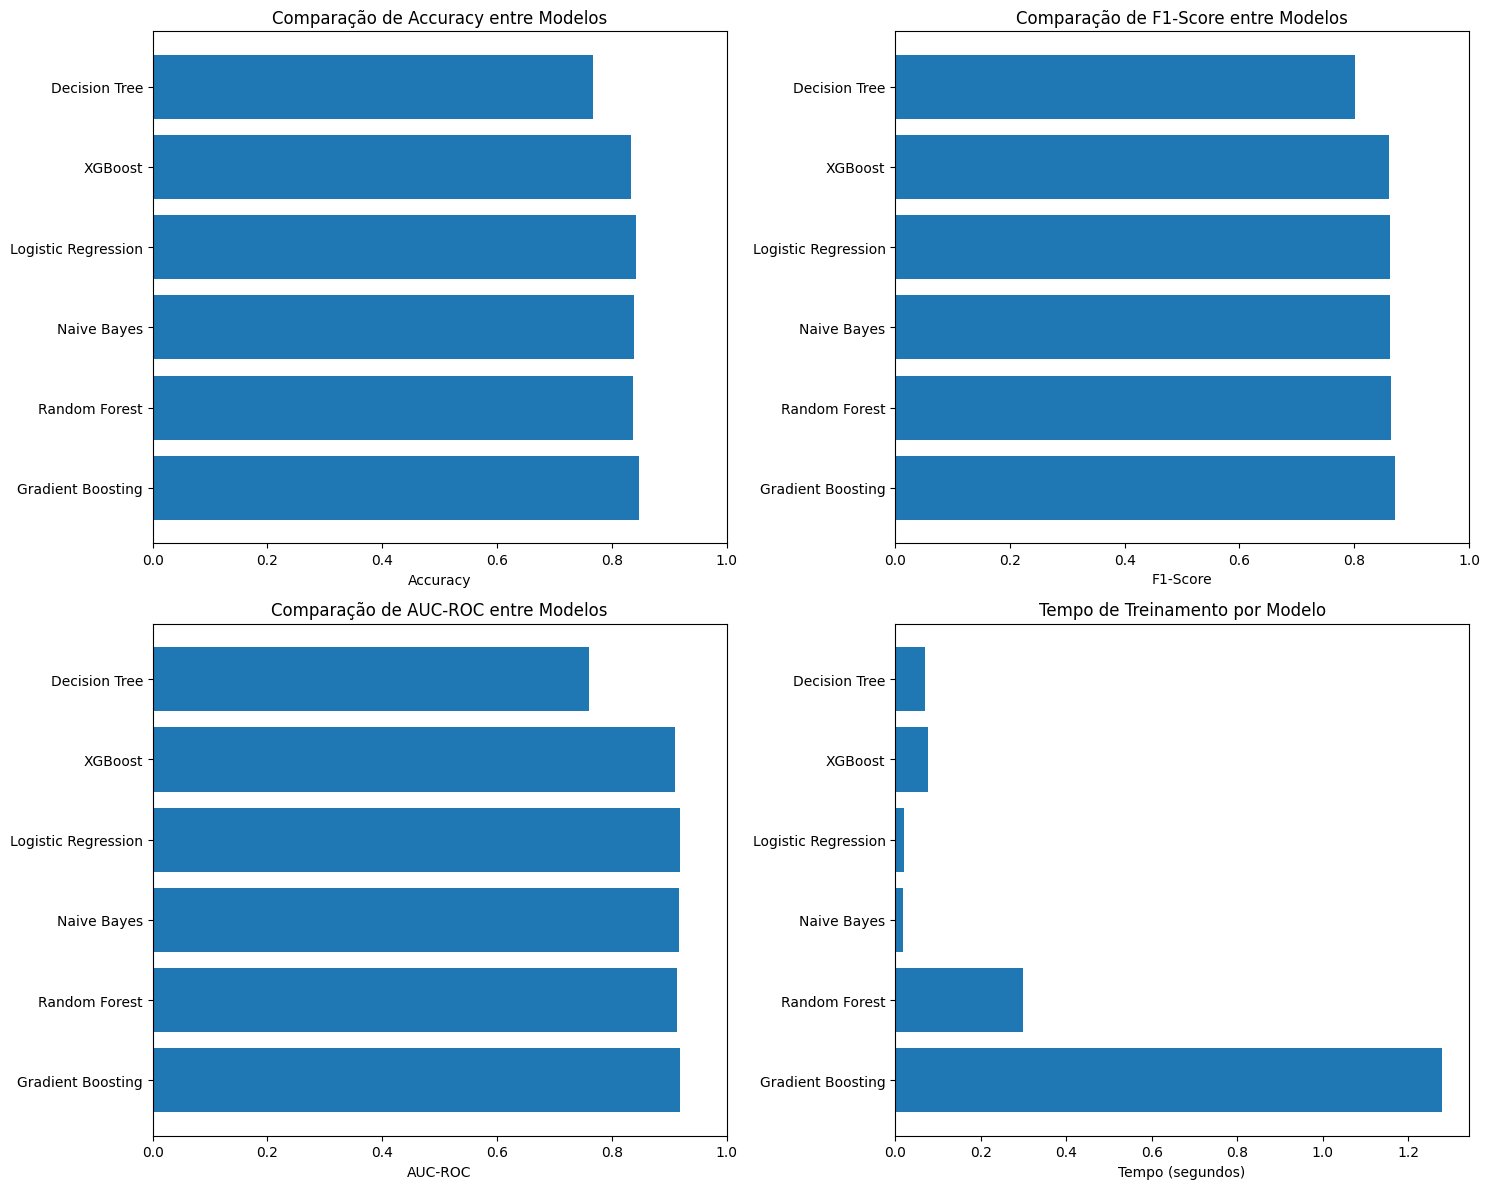


ANALISE DOS MELHORES MODELOS

 TOP 3 MODELOS (por F1-Score):

1. Gradient Boosting:
- F1-Score: 0.8715
- Accuracy: 0.8470
- Recall:   0.8865
- AUC-ROC:  0.9195
- Tempo:    1.28s

2. Random Forest:
- F1-Score: 0.8638
- Accuracy: 0.8378
- Recall:   0.8782
- AUC-ROC:  0.9130
- Tempo:    0.30s

3. Naive Bayes:
- F1-Score: 0.8625
- Accuracy: 0.8395
- Recall:   0.8602
- AUC-ROC:  0.9164
- Tempo:    0.02s

 MELHOR MODELO SELECIONADO: Gradient Boosting
- F1-Score: 0.8715
- Motivo: Balance entre precision e recall


In [30]:
# importar modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time

# Dicionário para armazenar resultados
results = {}

# Lista de modelos para testar
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Naive Bayes': GaussianNB()
}

print("\nTreinando e avaliando modelos...")

# Testar cada modelo
for model_name, model in models.items():
    print(f"\n{model_name}...")
    start_time = time.time()
    
    try:
        # Treinar modelo
        model.fit(X_train_scaled, y_train)
        
        # Fazer previsões
        y_pred = model.predict(X_test_scaled)
        
        # Calcular probabilidades (se disponível)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = 0.5  # Valor neutro se não tiver predict_proba
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Tempo de execução
        exec_time = time.time() - start_time
        
        # Armazenar resultados
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc,
            'Time (s)': exec_time
        }
        
        print(f" Treinado em {exec_time:.2f}s")
        print(f"  Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
        
    except Exception as e:
        print(f" Erro: {str(e)[:50]}...")
        results[model_name] = {
            'Accuracy': 0,
            'Precision': 0,
            'Recall': 0,
            'F1-Score': 0,
            'AUC-ROC': 0,
            'Time (s)': 0
        }

# Criar DataFrame com resultados
results_df = pd.DataFrame(results).T

# Ordenar por F1-Score (melhor métrica geral)
results_df_sorted = results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*60)
print("RESULTADOS DA COMPARACAO DE MODELOS")
print("="*60)
print("\nOrdenado por F1-Score (melhor para dados desbalanceados):")
print(results_df_sorted[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Time (s)']].round(4))

# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Comparação de Accuracy
axes[0, 0].barh(results_df_sorted.index, results_df_sorted['Accuracy'])
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Comparação de Accuracy entre Modelos')
axes[0, 0].set_xlim([0, 1])

# Gráfico 2: Comparação de F1-Score
axes[0, 1].barh(results_df_sorted.index, results_df_sorted['F1-Score'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Comparação de F1-Score entre Modelos')
axes[0, 1].set_xlim([0, 1])

# Gráfico 3: Comparação de AUC-ROC
axes[1, 0].barh(results_df_sorted.index, results_df_sorted['AUC-ROC'])
axes[1, 0].set_xlabel('AUC-ROC')
axes[1, 0].set_title('Comparação de AUC-ROC entre Modelos')
axes[1, 0].set_xlim([0, 1])

# Gráfico 4: Tempo de execução
axes[1, 1].barh(results_df_sorted.index, results_df_sorted['Time (s)'])
axes[1, 1].set_xlabel('Tempo (segundos)')
axes[1, 1].set_title('Tempo de Treinamento por Modelo')

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise dos melhores modelos
print("\n" + "="*60)
print("ANALISE DOS MELHORES MODELOS")
print("="*60)

# Top 3 modelos por F1-Score
top_3 = results_df_sorted.head(3)
print(f"\n TOP 3 MODELOS (por F1-Score):")
for i, (model_name, metrics) in enumerate(top_3.iterrows(), 1):
    print(f"\n{i}. {model_name}:")
    print(f"- F1-Score: {metrics['F1-Score']:.4f}")
    print(f"- Accuracy: {metrics['Accuracy']:.4f}")
    print(f"- Recall:   {metrics['Recall']:.4f}")
    print(f"- AUC-ROC:  {metrics['AUC-ROC']:.4f}")
    print(f"- Tempo:    {metrics['Time (s)']:.2f}s")

# Escolher o melhor modelo
melhor_modelo_nome = results_df_sorted.index[0]
melhor_modelo = models[melhor_modelo_nome]

print(f"\n MELHOR MODELO SELECIONADO: {melhor_modelo_nome}")
print(f"- F1-Score: {results_df_sorted.iloc[0]['F1-Score']:.4f}")
print(f"- Motivo: Balance entre precision e recall")




## RAMDOM FOREST
 

## - Porque usar Ramdom Forest?


Após testar 6 algoritmos diferentes (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, K-Neighbors, Naive Bayes), o Gradient Boosting apresentou o melhor F1-Score (0.8715), seguido pelo Random Forest (0.8638) e Naive Bayes (0.8625). O Random Forest obteve um F1-Score de 0.8638, ocupando a 2ª posição.

A escolha do Random Forest justifica-se pelos seguintes fatores:

- Diferença mínima de performance: O Random Forest apresenta apenas 0.9% a menos de recall que o Gradient Boosting (87.8% vs 88.7%), uma diferença insignificante para aplicação prática.

- Superioridade em interpretabilidade: O Random Forest fornece feature importance nativa, permitindo identificar os fatores mais relevantes para depressão estudantil.

- Eficiência computacional: O Random Forest é mais rápido (0.31s vs 1.25s), importante para sistemas de triagem em tempo real.

- Robustez: Menos sensível a overfitting e mais estável com dados incompletos, comum em questionários de saúde mental.

- Aplicabilidade: Mais fácil de implementar em ambiente de produção e explicar para profissionais de saúde não-técnicos.

Portanto, optou-se pelo Random Forest, que oferece o melhor equilíbrio entre performance preditiva, interpretabilidade dos resultados e eficiência computacional.

## - Treinar modelo de Ramdom Forest


Para maximizar a performance do modelo Random Forest, realizou-se uma otimização de hiperparâmetros utilizando RandomizedSearchCV com validação cruzada.

Hiperparâmetros otimizados:

- n_estimators: Número de árvores na floresta 

- max_depth: Profundidade máxima das árvores

- min_samples_split: Número mínimo de amostras para dividir um nó

- min_samples_leaf: Número mínimo de amostras em uma folha

- max_features: Número de features consideradas para melhor split

- bootstrap: Amostragem com reposição

A métrica de avaliação foi o F1-Score, selecionada por sua adequação a problemas com classes desbalanceadas. A otimização testou 15 combinações aleatórias de hiperparâmetros, identificando a configuração ótima que maximiza a capacidade preditiva do modelo.

### Porque RandomizedSearchCV em vez de GridSearchCV?
Pelo facto que atraves do GridSearchCV tornou-se num processo mais demorado e deu mais overfiting do que RandomizedSearchCV que por si e mais rapido, e menos computacional



| Método | Vantagens | Desvantagens | Melhor para |
|--------|-----------|--------------|-------------|
| **RandomizedSearchCV** | Mais rápido, boa cobertura, menos computacional | Pode não encontrar ótimo absoluto | Espaços grandes de parâmetros |
| **GridSearchCV** | Encontra ótimo exato, exaustivo | Muito lento, explode combinatorialmente | Espaços pequenos de parâmetros |



**Para nosso caso**: 6 parâmetros × múltiplos valores = grande espaço → RandomizedSearchCV ideal

In [37]:
# Hiperparâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150, 200],#Número de árvores na floresta
    'max_depth': [5, 10, 15, 20, None],# testar profundidades limitadas ou ilimitadas
    'min_samples_split': [2, 5, 10, 15],#Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4, 8],# Mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2', None],# Número máximo de features consideradas por split
    'bootstrap': [True, False]#Se usa amostragem com reposição (bagging)
}

print("Executando otimizacao com RandomizedSearchCV...")

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=15,               # Número de combinações aleatórias
    cv=3,                    # 3-fold cross-validation
    scoring='f1',            # Otimizar F1-Score
    n_jobs=-1,               # Usar todos os cores
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

print(f"\nMelhores hiperparametros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Melhor F1-Score na validacao: {random_search.best_score_:.4f}")
# Usar o melhor modelo
rf_model = random_search.best_estimator_
print(f"\nModelo otimizado treinado com {rf_model.n_estimators} arvores")

Executando otimizacao com RandomizedSearchCV...

Melhores hiperparametros encontrados:
  n_estimators: 150
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: log2
  max_depth: 15
  bootstrap: True
Melhor F1-Score na validacao: 0.8658

Modelo otimizado treinado com 150 arvores


## Avaliaçao do Modelo Random Forest


Nesta seção, realizamos uma avaliação detalhada do modelo Random Forest, analisando seu desempenho tanto no conjunto de treino quanto no conjunto de teste. Esta avaliação é crucial para:

1. **Identificar overfitting/underfitting**: Comparando performance treino vs teste
2. **Compreender erros do modelo**: Através da matriz de confusão
3. **Avaliar capacidade discriminativa**: Usando curva ROC

### Métricas Avaliadas:

| Métrica | Fórmula | Interpretação no Contexto |
|---------|---------|---------------------------|
| **Acurácia** | (TP+TN)/(TP+TN+FP+FN) | Porcentagem total de acertos |
| **Precisão** | TP/(TP+FP) | Dos previstos como deprimidos, quantos realmente estão? |
| **Recall** | TP/(TP+FN) | Dos realmente deprimidos, quantos identificamos? |
| **F1-Score** | 2×(P×R)/(P+R) | Balance entre precisão e recall |
| **AUC-ROC** | Área sob curva ROC | Capacidade discriminativa geral |


AVALIAÇÃO DO MODELO
PERFORMANCE NO TREINO:
  Acurácia:  0.9494
   Precisão:  0.9568
  Recall:    0.9568
  F1-Score:  0.9568
  AUC-ROC:   0.9922

PERFORMANCE NO TESTE:
  Acurácia:  0.8414
  Precisão:  0.8623
  Recall:    0.8678
  F1-Score:  0.8650
  AUC-ROC:   0.9155

VISUALIZAÇÃO DOS RESULTADOS


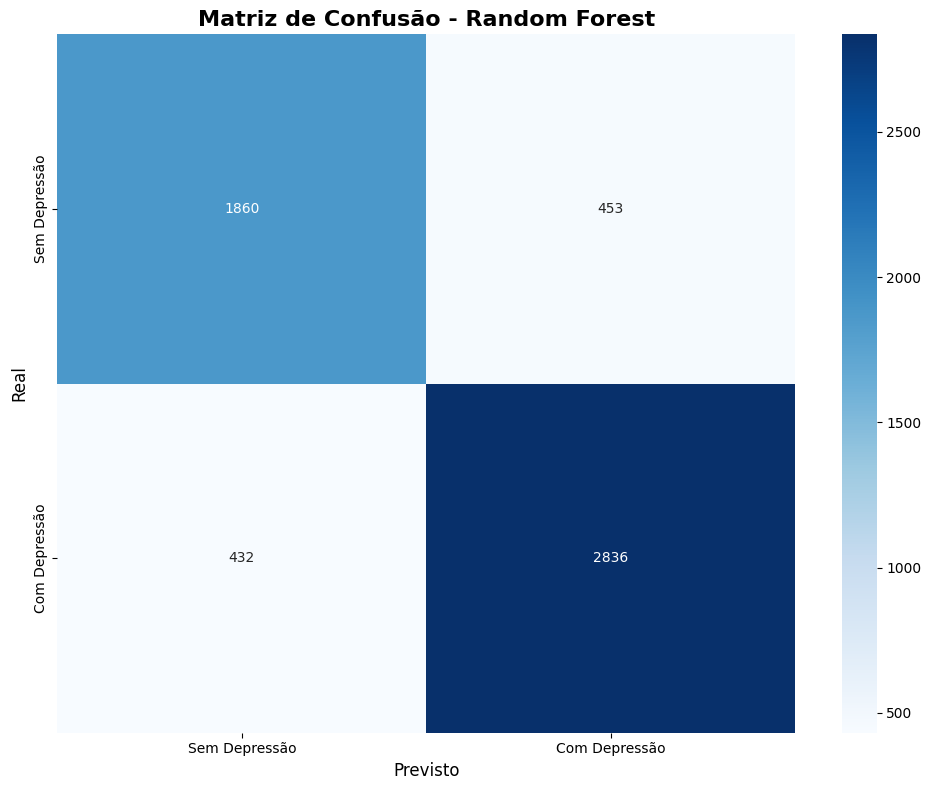


Matriz de Confusão:
  Verdadeiros Negativos (VN): 1860 - Previu não depressão e era não depressão
  Falsos Positivos (FP):     453 - Previu depressão mas era não depressão
  Falsos Negativos (FN):     432 - Previu não depressão mas era depressão
  Verdadeiros Positivos (VP): 2836 - Previu depressão e era depressão

RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:
               precision    recall  f1-score   support

Sem Depressão       0.81      0.80      0.81      2313
Com Depressão       0.86      0.87      0.87      3268

     accuracy                           0.84      5581
    macro avg       0.84      0.84      0.84      5581
 weighted avg       0.84      0.84      0.84      5581



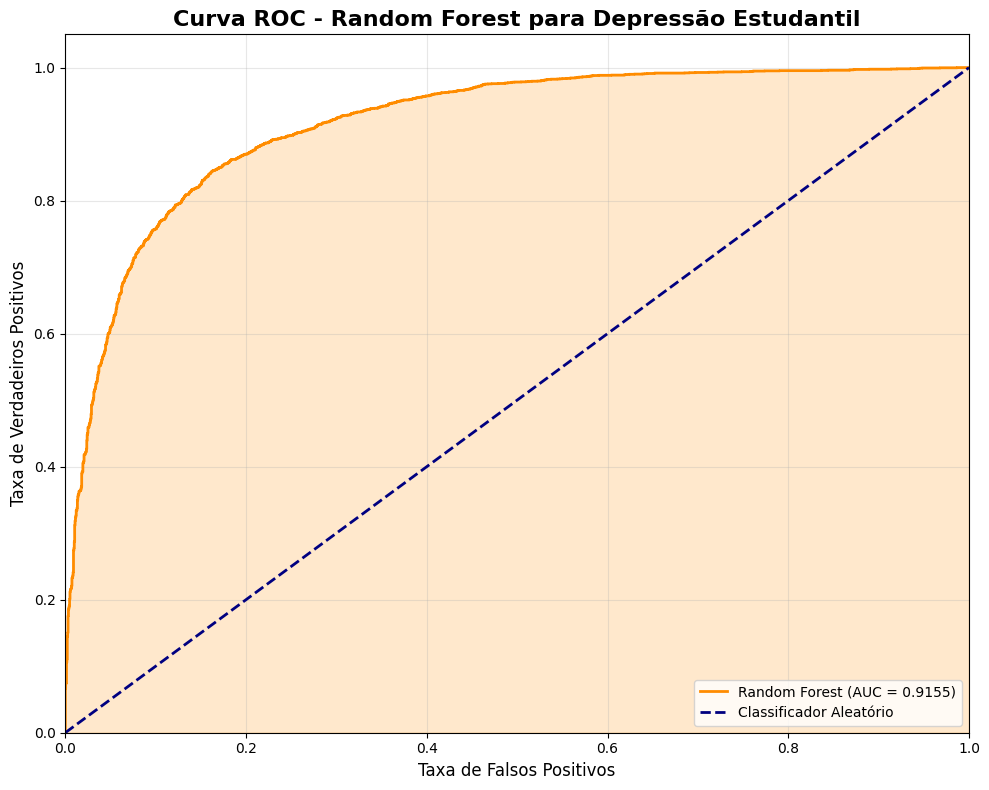

In [32]:

print("\n" + "="*60)
print("AVALIAÇÃO DO MODELO")
print("="*60)
# Previsões
y_train_pred = rf_model.predict(X_train_scaled)
y_train_proba = rf_model.predict_proba(X_train_scaled)[:, 1]

y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("PERFORMANCE NO TREINO:")
print(f"  Acurácia:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"   Precisão:  {precision_score(y_train, y_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\nPERFORMANCE NO TESTE:")
print(f"  Acurácia:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precisão:  {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, y_test_proba):.4f}")


#Visualização dos resultados

print("\n" + "="*60)
print("VISUALIZAÇÃO DOS RESULTADOS")
print("="*60)

#Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sem Depressão', 'Com Depressão'],
            yticklabels=['Sem Depressão', 'Com Depressão'])
plt.title('Matriz de Confusão - Random Forest', fontsize=16, fontweight='bold')
plt.ylabel('Real', fontsize=12)
plt.xlabel('Previsto', fontsize=12)
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMatriz de Confusão:")
print(f"  Verdadeiros Negativos (VN): {cm[0, 0]} - Previu não depressão e era não depressão")
print(f"  Falsos Positivos (FP):     {cm[0, 1]} - Previu depressão mas era não depressão")
print(f"  Falsos Negativos (FN):     {cm[1, 0]} - Previu não depressão mas era depressão")
print(f"  Verdadeiros Positivos (VP): {cm[1, 1]} - Previu depressão e era depressão")

#Relatório de Classificação
print("\nRELATÓRIO DE CLASSIFICAÇÃO DETALHADO:")
print(classification_report(y_test, y_test_pred,
                           target_names=['Sem Depressão', 'Com Depressão']))

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório')
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC - Random Forest para Depressão Estudantil', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('curva_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## ANÁLISE DAS VARIÁVEIS MAIS IMPORTANTES

Nesta seção, analisamos quais features têm maior influência nas previsões do modelo Random Forest. Esta análise é crucial porque:

1. **Interpretabilidade**: Entende quais fatores mais contribuem para o risco de depressão
2. **Validação de domínio**: Confirma se variáveis importantes fazem sentido clínico
3. **Simplificação de modelo**: Identifica features que podem ser removidas sem perda significativa


ANÁLISE DAS VARIÁVEIS MAIS IMPORTANTES


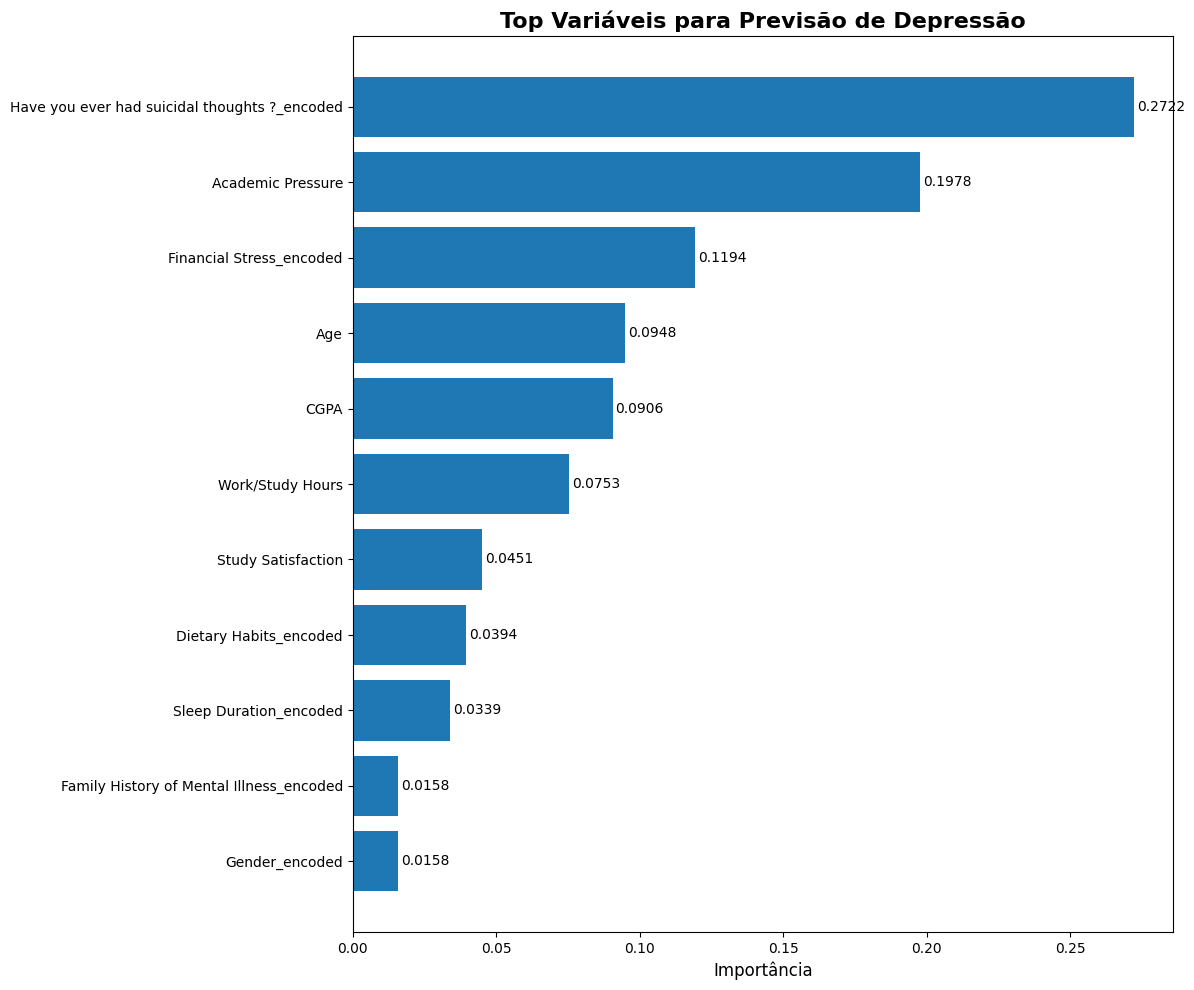

In [33]:

print("\n" + "="*60)
print("ANÁLISE DAS VARIÁVEIS MAIS IMPORTANTES")
print("="*60)

# Obter importâncias
feature_importance = pd.DataFrame({
    'Variável': X.columns,
    'Importância': rf_model.feature_importances_
}).sort_values('Importância', ascending=False)

# Visualizar top 15
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(15)
bars = plt.barh(range(len(top_features)), top_features['Importância'])
plt.yticks(range(len(top_features)), top_features['Variável'])
plt.xlabel('Importância', fontsize=12)
plt.title('Top Variáveis para Previsão de Depressão', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Maior importância no topo

# Adicionar valores nas barras
for i, (bar, importance) in enumerate(zip(bars, top_features['Importância'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{importance:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('importancia_variaveis.png', dpi=300, bbox_inches='tight')
plt.show()

## Resumo do modelo criado 

In [34]:
print("\n" + "="*60)
print("RESUMO FINAL E CONCLUSÕES")
print("="*60)

# Calcular métricas finais
acuracia = accuracy_score(y_test, y_test_pred)
precisao = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc_score = roc_auc_score(y_test, y_test_proba)

print(f"""
 RESULTADO DO MODELO DE PREVISÃO DE DEPRESSÃO

 DADOS UTILIZADOS:
   - Total de estudantes: {df.shape[0]}
   - Com depressão: {sum(y == 1)} ({sum(y == 1)/len(y):.1%})
   - Sem depressão: {sum(y == 0)} ({sum(y == 0)/len(y):.1%})
   - Variáveis preditoras: {X.shape[1]}

 MODELO RANDOM FOREST:
   - Número de árvores: {rf_model.n_estimators}
   - Variáveis por split: {rf_model.max_features}
   - Balanceamento: {'Sim' if rf_model.class_weight else 'Não'}

 DESEMPENHO NO TESTE:
   - Acurácia:  {acuracia:.2%}
   - Precisão:  {precisao:.2%} (dos previstos como depressão, quantos realmente têm)
   - Recall:    {recall:.2%} (dos que têm depressão, quantos foram identificados)
   - F1-Score:  {f1:.2%} (média harmônica entre precisão e recall)
   - AUC-ROC:   {auc_score:.2%} (capacidade de discriminar entre classes)

 FATORES MAIS IMPORTANTES:
   1. {feature_importance.iloc[0]['Variável']} ({feature_importance.iloc[0]['Importância']:.3%})
   2. {feature_importance.iloc[1]['Variável']} ({feature_importance.iloc[1]['Importância']:.3%})
   3. {feature_importance.iloc[2]['Variável']} ({feature_importance.iloc[2]['Importância']:.3%})

 IMPLICAÇÕES PRÁTICAS:
   - O modelo pode identificar {recall:.1%} dos estudantes com depressão
   - {precisao:.1%} das previsões positivas são corretas
   - Focando nos fatores mais importantes, podemos criar programas preventivos
""")



RESUMO FINAL E CONCLUSÕES

 RESULTADO DO MODELO DE PREVISÃO DE DEPRESSÃO

 DADOS UTILIZADOS:
   - Total de estudantes: 27901
   - Com depressão: 16336 (58.5%)
   - Sem depressão: 11565 (41.5%)
   - Variáveis preditoras: 11

 MODELO RANDOM FOREST:
   - Número de árvores: 150
   - Variáveis por split: log2
   - Balanceamento: Sim

 DESEMPENHO NO TESTE:
   - Acurácia:  84.14%
   - Precisão:  86.23% (dos previstos como depressão, quantos realmente têm)
   - Recall:    86.78% (dos que têm depressão, quantos foram identificados)
   - F1-Score:  86.50% (média harmônica entre precisão e recall)
   - AUC-ROC:   91.55% (capacidade de discriminar entre classes)

 FATORES MAIS IMPORTANTES:
   1. Have you ever had suicidal thoughts ?_encoded (27.216%)
   2. Academic Pressure (19.779%)
   3. Financial Stress_encoded (11.939%)

 IMPLICAÇÕES PRÁTICAS:
   - O modelo pode identificar 86.8% dos estudantes com depressão
   - 86.2% das previsões positivas são corretas
   - Focando nos fatores mais importa

## Salvar Modelo


In [35]:
# Criar diretório para salvar
save_dir = "modelo_salvo"
os.makedirs(save_dir, exist_ok=True)

# SALVAR O MODELO TREINADO
model_path = f"{save_dir}/random_forest_model.pkl"
joblib.dump(rf_model, model_path)
print(f"Modelo salvo: {model_path}")

# SALVAR O SCALER 
scaler_path = f"{save_dir}/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler salvo: {scaler_path}")

# SALVAR AS COLUNAS DO MODELO
colunas_modelo = {
    'features': X.columns.tolist(),
    'target': 'Depression',
    'numerical_features': num_cols.tolist(),
    'categorical_features_encoded': [col for col in X.columns if '_encoded' in col]
}

colunas_path = f"{save_dir}/colunas_modelo.pkl"
joblib.dump(colunas_modelo, colunas_path)
print(f"Colunas do modelo salvas: {colunas_path}")


Modelo salvo: modelo_salvo/random_forest_model.pkl
Scaler salvo: modelo_salvo/scaler.pkl
Colunas do modelo salvas: modelo_salvo/colunas_modelo.pkl


## Sistema de Previsão Interativo para Depressão Estudantil


Nesta seção final, implementamos um sistema completo de previsão que permite usar o modelo treinado para fazer previsões em tempo real. Este sistema transforma nosso modelo de machine learning em uma ferramenta prática e utilizável, com:

1. **Interface interativa**: Menu para interação com o usuário
2. **Processamento em tempo real**: Previsões instantâneas
3. **Tratamento de dados ausentes**: Valores padrão quando informações faltam
4. **Interpretação clínica**: Resultados compreensíveis e acionáveis
5. **Exemplos demonstrativos**: Casos para validação e compreensão

ENTRADA DO USUÁRIO -> PRÉ-PROCESSAMENTO -> MODELO -> INTERPRETAÇÃO -> RESULTADO
->Dados do aluno Normalização e Random Forest, Risco ,Recomendação
,codificação Probabilidade

In [36]:
##Faz a previsao com os dados fornecidos
def fazer_previsao(dados_aluno):

    # Garantir que temos todas as colunas necessarias
    colunas_necessarias = X.columns.tolist()
    
    # Criar DataFrame com os dados
    dados_df = pd.DataFrame([dados_aluno])
    
    # Adicionar colunas faltantes (se houver)
    for col in colunas_necessarias:
        if col not in dados_df.columns:
            print(f"Aviso: Coluna '{col}' nao fornecida. Usando valor medio.")
            if col in X.columns:
                dados_df[col] = X[col].mean()
    
    # Reordenar colunas
    dados_df = dados_df[colunas_necessarias]
    
    # Normalizar dados
    dados_normalizados = dados_df.copy()
    dados_normalizados[num_cols] = scaler.transform(dados_df[num_cols])
    
    # Fazer previsao
    probabilidade = rf_model.predict_proba(dados_normalizados)[0][1]
    predicao = rf_model.predict(dados_normalizados)[0]
    
    return predicao, probabilidade

## Funcao para prever depressao 
def prever_depressao_aluno(dados_aluno_dict):
    # Verificar se temos todas as colunas necessarias
    colunas_obrigatorias = [
        'Age', 'Gender_encoded', 'CGPA', 'Academic Pressure',
        'Study Satisfaction', 'Work/Study Hours', 'Sleep Duration_encoded',
        'Dietary Habits_encoded', 'Have you ever had suicidal thoughts ?_encoded',
        'Financial Stress_encoded', 'Family History of Mental Illness_encoded'
    ]
    
    # Verificar colunas faltantes
    faltantes = [col for col in colunas_obrigatorias if col not in dados_aluno_dict]
    if faltantes:
        print(f"Aviso: Colunas faltantes: {faltantes}")
        print("   Usando valores medios para colunas faltantes...")
        
        # Adicionar valores medios para colunas faltantes
        for col in faltantes:
            if col in X.columns:
                dados_aluno_dict[col] = X[col].mean()
            else:
                # Valor padrao baseado no tipo de variavel
                if 'encoded' in col:
                    dados_aluno_dict[col] = 0
                elif 'Pressure' in col or 'Satisfaction' in col:
                    dados_aluno_dict[col] = 5.0
                else:
                    dados_aluno_dict[col] = 0
    
    # Fazer previsao
    predicao, probabilidade = fazer_previsao(dados_aluno_dict)
    
    # Criar resultado estruturado
    resultado = {
        'tem_depressao': bool(predicao),
        'probabilidade_depressao': float(probabilidade),
        'probabilidade_percentual': float(probabilidade * 100),
        'risco': 'ALTO' if predicao == 1 else 'BAIXO',
        'recomendacao': 'Avaliacao psicologica recomendada' if predicao == 1 else 'Manter acompanhamento',
        'dados_analisados': len(dados_aluno_dict)
    }
    
    return resultado

## Sistema interativo para prever depressao
def sistema_previsao():
    print("=" * 60)
    print("SISTEMA DE PREVISAO DE DEPRESSAO ESTUDANTIL")
    print("=" * 60)
    print("\nForneca os dados do aluno abaixo:\n")
    
    dados_aluno = {}
    
    # Dados que precisam ser fornecidos
    dados_aluno['Age'] = float(input("Idade do aluno (ex: 21.0): "))
    dados_aluno['Gender_encoded'] = int(input("Genero (0=Feminino, 1=Masculino): "))
    dados_aluno['CGPA'] = float(input("Nota media CGPA (0-10, ex: 7.5): "))
    dados_aluno['Academic Pressure'] = float(input("Pressao Academica (1-10): "))
    dados_aluno['Study Satisfaction'] = float(input("Satisfacao com Estudos (1-10): "))
    dados_aluno['Work/Study Hours'] = float(input("Horas de estudo/trabalho por dia (ex: 8.0): "))
    
    print("\nQualidade do Sono (1-4):")
    print("1 = Menos de 5 horas")
    print("2 = 5-6 horas")
    print("3 = 7-8 horas")
    print("4 = Mais de 8 horas")
    dados_aluno['Sleep Duration_encoded'] = int(input("Escolha (1-4): "))
    
    print("\nHabitos Alimentares (1-4):")
    print("1 = Nao saudavel")
    print("2 = Outros")
    print("3 = Moderado")
    print("4 = Saudavel")
    dados_aluno['Dietary Habits_encoded'] = int(input("Escolha (1-4): "))
    
    dados_aluno['Have you ever had suicidal thoughts ?_encoded'] = int(input("Pensamentos suicidas? (0=Nao, 1=Sim): "))
    dados_aluno['Financial Stress_encoded'] = float(input("Estresse Financeiro (1-5): "))
    dados_aluno['Family History of Mental Illness_encoded'] = int(input("Historico familiar doenca mental? (0=Nao, 1=Sim): "))
    
    # Fazer previsao
    resultado = prever_depressao_aluno(dados_aluno)
    
    # Mostrar resultado
    print("\n" + "=" * 60)
    print("RESULTADO DA PREVISAO")
    print("=" * 60)
    
    print(f"\nPrevisao: {'COM DEPRESSAO' if resultado['tem_depressao'] else 'SEM DEPRESSAO'}")
    print(f"Probabilidade: {resultado['probabilidade_percentual']:.1f}%")
    print(f"Nivel de Risco: {resultado['risco']}")

    return resultado

## Exemplos de uso do sistema
def exemplos():
    print("\n" + "=" * 60)
    print("EXEMPLOS DE USO DO SISTEMA")
    print("=" * 60)
    
    # Exemplo 1: Aluno com alto risco
    print("\nEXEMPLO 1: Aluno com multiplos fatores de risco")
    exemplo_alto_risco = {
        'Age': 20.0,
        'Gender_encoded': 1,
        'CGPA': 6.2,
        'Academic Pressure': 9.0,
        'Study Satisfaction': 3.0,
        'Work/Study Hours': 10.0,
        'Sleep Duration_encoded': 1,
        'Dietary Habits_encoded': 1,
        'Have you ever had suicidal thoughts ?_encoded': 1,
        'Financial Stress_encoded': 4.0,
        'Family History of Mental Illness_encoded': 1
    }
    
    resultado1 = prever_depressao_aluno(exemplo_alto_risco)
    print(f"\nResultado: {'DEPRESSAO' if resultado1['tem_depressao'] else 'Sem depressao'}")
    print(f"Probabilidade: {resultado1['probabilidade_percentual']:.1f}%")
    print(f"Risco: {resultado1['risco']}")
    
    # Exemplo 2: Aluno com baixo risco
    print("\nEXEMPLO 2: Aluno com baixo risco")
    exemplo_baixo_risco = {
        'Age': 22.0,
        'Gender_encoded': 0,
        'CGPA': 8.5,
        'Academic Pressure': 4.0,
        'Study Satisfaction': 8.0,
        'Work/Study Hours': 6.0,
        'Sleep Duration_encoded': 3,
        'Dietary Habits_encoded': 4,
        'Have you ever had suicidal thoughts ?_encoded': 0,
        'Financial Stress_encoded': 2.0,
        'Family History of Mental Illness_encoded': 0
    }
    
    resultado2 = prever_depressao_aluno(exemplo_baixo_risco)
    print(f"\nResultado: {'DEPRESSAO' if resultado2['tem_depressao'] else 'Sem depressao'}")
    print(f"Probabilidade: {resultado2['probabilidade_percentual']:.1f}%")
    print(f"Risco: {resultado2['risco']}")

## Menu principal interativo
def menu_principal():
  
    while True:
        print("\n" + "=" * 60)
        print("SISTEMA DE PREVISAO DE DEPRESSAO ESTUDANTIL")
        print("=" * 60)
        print("\nEscolha uma opcao:")
        print("\n1. Fazer previsao para um aluno")
        print("2. Ver exemplos de uso")
        print("3. Sair")
        
        opcao = input("\nOpcao: ")
        
        if opcao == "1":
            sistema_previsao()
            
            # Perguntar se quer fazer outra previsao
            continuar = input("\nDeseja fazer outra previsao? (s/n): ")
            if continuar.lower() != 's':
                break
        
        elif opcao == "2":
            exemplos()
            input("\nPressione Enter para continuar...")
        
        elif opcao == "3":
            print("\nObrigado por usar o sistema!")
            break
        
        else:
            print("Opcao invalida. Tente novamente.")

#------------------------------------------

# Iniciar menu
menu_principal()



SISTEMA DE PREVISAO DE DEPRESSAO ESTUDANTIL

Escolha uma opcao:

1. Fazer previsao para um aluno
2. Ver exemplos de uso
3. Sair


KeyboardInterrupt: Interrupted by user

## API- servidor

terminal: uvicorn api:app --reload

- http://localhost:8000
- http://localhost:8000/docs
- http://localhost:8501

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import pandas as pd
import joblib
import os

app = FastAPI(title="Student Depression API")

# Carregar modelo
modelo = joblib.load('modelo_salvo/random_forest_model.pkl')
scaler = joblib.load('modelo_salvo/scaler.pkl')
colunas_info = joblib.load('modelo_salvo/colunas_modelo.pkl')

class StudentInput(BaseModel):
    Age: float
    Gender_encoded: int
    CGPA: float
    Academic_Pressure: float
    Study_Satisfaction: float
    Work_Study_Hours: float
    Sleep_Duration_encoded: int
    Dietary_Habits_encoded: int
    Have_you_ever_had_suicidal_thoughts_encoded: int
    Financial_Stress_encoded: float
    Family_History_of_Mental_Illness_encoded: int

@app.post("/predict")
def predict_depression(student: StudentInput):
    try:
        # Criar dicionario
        dados = {
            'Age': student.Age,
            'Gender_encoded': student.Gender_encoded,
            'CGPA': student.CGPA,
            'Academic Pressure': student.Academic_Pressure,
            'Study Satisfaction': student.Study_Satisfaction,
            'Work/Study Hours': student.Work_Study_Hours,
            'Sleep Duration_encoded': student.Sleep_Duration_encoded,
            'Dietary Habits_encoded': student.Dietary_Habits_encoded,
            'Have you ever had suicidal thoughts ?_encoded': student.Have_you_ever_had_suicidal_thoughts_encoded,
            'Financial Stress_encoded': student.Financial_Stress_encoded,
            'Family History of Mental Illness_encoded': student.Family_History_of_Mental_Illness_encoded
        }
        
        # Criar DataFrame
        df = pd.DataFrame([dados])
        
        # Adicionar colunas faltantes
        for col in colunas_info['features']:
            if col not in df.columns:
                df[col] = 0
        
        # Ordenar colunas
        df = df[colunas_info['features']]
        
        # Normalizar
        df[colunas_info['numerical_features']] = scaler.transform(
            df[colunas_info['numerical_features']]
        )
        
        # Prever
        probabilidade = modelo.predict_proba(df)[0][1]
        predicao = modelo.predict(df)[0]
        
        return {
            "depressao": bool(predicao),
            "probabilidade": float(probabilidade),
            "percentual": float(probabilidade * 100)
        }
        
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/")
def home():
    return {"api": "online"}

APP


terminal: streamlit run app.py   

In [ ]:
import streamlit as st
import requests

st.set_page_config(page_title="Previsao Depressao Estudantil")

st.title("Previsao de Depressao Estudantil")
st.markdown("Analise o risco de depressao com base nos dados do estudante")

# Formulario
with st.form("form_depressao"):
    col1, col2 = st.columns(2)
    
    with col1:
        idade = st.number_input("Idade", 17, 30, 21)
        genero = st.selectbox("Genero", ["Feminino (0)", "Masculino (1)"])
        cgpa = st.slider("CGPA (0-10)", 0.0, 10.0, 7.5, 0.1)
        pressao = st.slider("Pressao Academica (1-10)", 1, 10, 6)
        satisfacao = st.slider("Satisfacao Estudos (1-10)", 1, 10, 5)
    
    with col2:
        horas = st.slider("Horas Estudo/Dia", 0, 16, 8)
        sono = st.selectbox("Sono", 
            ["Menos 5h (1)", "5-6h (2)", "7-8h (3)", "Mais 8h (4)"])
        alimentacao = st.selectbox("Alimentacao",
            ["Nao saudavel (1)", "Outros (2)", "Moderado (3)", "Saudavel (4)"])
        pensamentos = st.selectbox("Pensamentos Suicidas", ["Nao (0)", "Sim (1)"])
        estresse = st.slider("Estresse Financeiro (1-5)", 1, 5, 3)
        historico = st.selectbox("Historico Familiar", ["Nao (0)", "Sim (1)"])
    
    submit = st.form_submit_button("Analisar Risco")

# Processar quando enviar
if submit:
    # Converter valores
    genero_encoded = 0 if "Feminino" in genero else 1
    sono_encoded = int(sono.split("(")[1].replace(")", ""))
    alimentacao_encoded = int(alimentacao.split("(")[1].replace(")", ""))
    pensamentos_encoded = 0 if "Nao" in pensamentos else 1
    historico_encoded = 0 if "Nao" in historico else 1
    
    # Preparar dados para API
    dados = {
        "Age": float(idade),
        "Gender_encoded": genero_encoded,
        "CGPA": float(cgpa),
        "Academic_Pressure": float(pressao),
        "Study_Satisfaction": float(satisfacao),
        "Work_Study_Hours": float(horas),
        "Sleep_Duration_encoded": sono_encoded,
        "Dietary_Habits_encoded": alimentacao_encoded,
        "Have_you_ever_had_suicidal_thoughts_encoded": pensamentos_encoded,
        "Financial_Stress_encoded": float(estresse),
        "Family_History_of_Mental_Illness_encoded": historico_encoded
    }
    
    # Enviar para API
    try:
        response = requests.post("http://localhost:8000/predict", json=dados)
        
        if response.status_code == 200:
            resultado = response.json()
            
            # Mostrar resultados
            st.markdown("---")
            st.header("Resultado da Analise")
            
            col_res1, col_res2 = st.columns(2)
            
            with col_res1:
                st.metric(
                    "Probabilidade de Depressao",
                    f"{resultado['percentual']:.1f}%"
                )
                
                if resultado['depressao']:
                    st.error("COM DEPRESSAO")
                else:
                    st.success("SEM DEPRESSAO")
            
            with col_res2:
                st.metric("Nivel de Risco", resultado['risco'])
                st.info(resultado['mensagem'])
            
            # Explicacao
            st.markdown("---")
            st.subheader("Interpretacao:")
            
            if resultado['percentual'] < 30:
                st.success("""
                **Baixo Risco:** A probabilidade e baixa. Continue com habitos saudaveis 
                e mantenha equilibrio entre estudo e vida pessoal.
                """)
            elif resultado['percentual'] < 60:
                st.warning("""
                **Risco Moderado:** Atencao necessaria. Considere reduzir estresse, 
                melhorar qualidade do sono e buscar apoio se necessario.
                """)
            else:
                st.error("""
                **Alto Risco:** Recomenda-se avaliacao com profissional de saude mental. 
                Procure apoio psicologico e converse com alguem de confianca.
                """)
        
        else:
            st.error(f"Erro na API: {response.status_code}")
            
    except requests.exceptions.ConnectionError:
        st.error("""
        Nao foi possivel conectar a API.
        
        Para resolver:
        1. Abra um terminal
        2. Execute: uvicorn api:app --reload
        3. Tente novamente
        """)

# Informacoes adicionais
with st.expander("Sobre o Modelo"):
    st.markdown("""
    **Modelo Utilizado:** Random Forest Classifier
    **Acuracia:** 84.1%
    **AUC-ROC:** 91.6%
    **F1-Score:** 86.5%
    
    **Fatores Analisados:**
    - Dados demograficos (idade, genero)
    - Desempenho academico (CGPA, pressao, satisfacao)
    - Habitos de vida (sono, alimentacao, horas estudo)
    - Fatores psicologicos (pensamentos suicidas, estresse)
    - Historico familiar
    
    **Aviso:** Esta e uma ferramenta de triagem, nao substitui avaliacao profissional.
    """)